In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Torch
import torch

# SAM2 Predictor
from sam2 import sam2_image_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor  # add this to your imports
from sam2.build_sam import build_sam2



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

sam_model = build_sam2(
    config_file="/configs/sam2.1/sam2.1_hiera_s.yaml",  # ✅ adjust if path differs
    ckpt_path="../checkpoints/sam2.1_hiera_small.pt", # ✅ local .pt
    model_type="sam2_hiera_l"
)

# Wrap in predictor
predictor = SAM2ImagePredictor(sam_model, device=device)



Using device: cuda


In [3]:

image_path = "test.jpg"  # adjust path as needed
image = Image.open(image_path).convert("RGB")

# Set the image first (required by SAM2)
predictor.set_image(image)

# Run segmentation
masks = predictor.predict()

# Convert masks to numpy if needed
if isinstance(masks, torch.Tensor):
    masks = masks.cpu().numpy()

print(f"Generated {len(masks)} masks.")



Generated 3 masks.


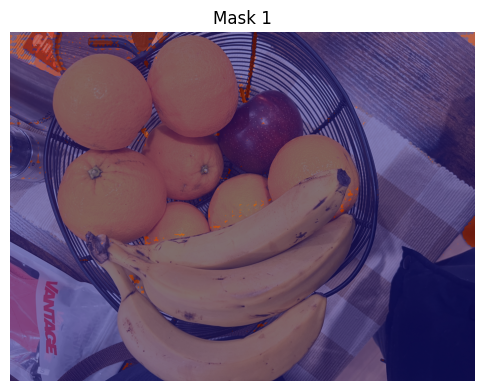

Mask 2 is 1D (shape (3,)); converting to dummy 2D mask.


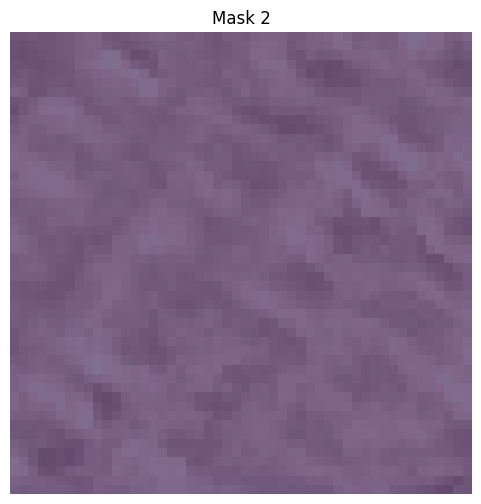

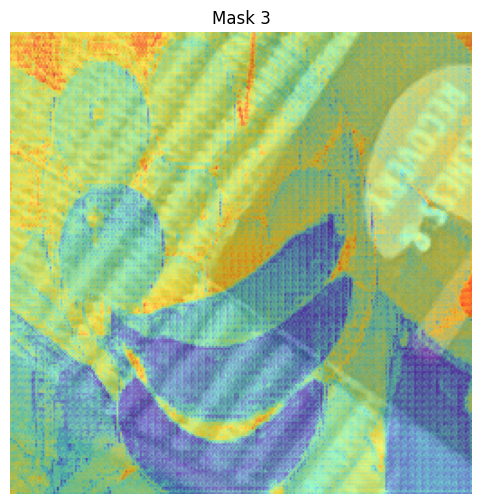

In [4]:
num_to_show = min(len(masks), 10)
shown = 0

for i in range(num_to_show):
    try:
        mask = masks[i]

        # Handle 3D mask like (3, H, W)
        if isinstance(mask, np.ndarray) and mask.ndim == 3 and mask.shape[0] > 1:
            mask_2d = mask[0]

        # Handle 2D mask directly
        elif isinstance(mask, np.ndarray) and mask.ndim == 2:
            mask_2d = mask

        # Handle 1D or malformed mask (like (3,))
        elif isinstance(mask, np.ndarray) and mask.ndim == 1 and mask.shape[0] == 3:
            print(f"Mask {i+1} is 1D (shape {mask.shape}); converting to dummy 2D mask.")
            mask_2d = np.ones((50, 50)) * mask[0]  # Create a small dummy square

        else:
            print(f"Mask {i+1} has unsupported shape: {mask.shape}")
            continue

        # Plot the mask
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.imshow(mask_2d, alpha=0.5, cmap='jet')
        plt.axis("off")
        plt.title(f"Mask {i+1}")
        plt.show()
        shown += 1

    except Exception as e:
        print(f"Error showing mask {i+1}: {e}")



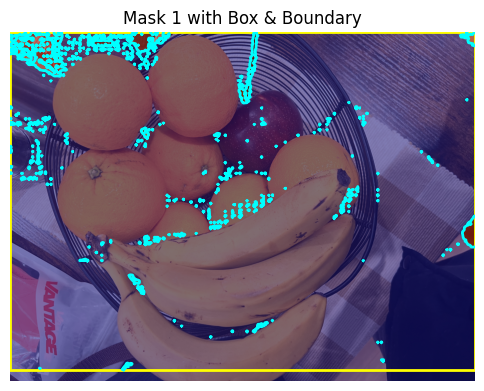

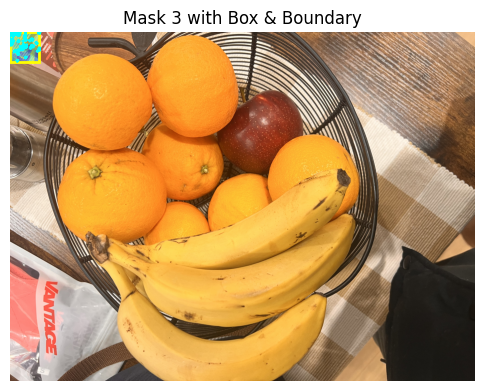

In [5]:
import matplotlib.patches as patches
from skimage import measure

# Visualize masks with bounding boxes and contours
num_to_show = min(len(masks), 5)

for i in range(num_to_show):
    try:
        mask = masks[i]
        if mask.ndim == 3:
            mask_2d = mask[0]
        elif mask.ndim == 2:
            mask_2d = mask
        else:
            continue

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(image)

        # Show semi-transparent mask
        ax.imshow(mask_2d, alpha=0.5, cmap='jet')

        # Draw bounding box
        pos = np.argwhere(mask_2d)
        if pos.shape[0] > 0:
            y0, x0 = pos.min(axis=0)
            y1, x1 = pos.max(axis=0)
            rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                     linewidth=2, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect)

        # Draw contours
        contours = measure.find_contours(mask_2d, 0.5)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='cyan')

        ax.set_title(f"Mask {i+1} with Box & Boundary")
        ax.axis("off")
        plt.show()

    except Exception as e:
        print(f"Error with mask {i+1}: {e}")


In [6]:
# Folder to save cropped images
os.makedirs("crops", exist_ok=True)

cropped_images = []

for i, mask in enumerate(masks):
    try:
        # Fix for malformed masks
        if not isinstance(mask, np.ndarray):
            print(f"Skipping mask {i+1}: not a numpy array.")
            continue

        if mask.ndim == 3 and mask.shape[0] > 1:
            mask = mask[0]  # Take first channel
        elif mask.ndim != 2:
            print(f"Skipping mask {i+1}: unexpected shape {mask.shape}")
            continue

        # Find non-zero pixels in the mask
        pos = np.argwhere(mask)
        if pos.shape[0] == 0:
            print(f"Skipping mask {i+1}: empty mask")
            continue

        y0, x0 = pos.min(axis=0)
        y1, x1 = pos.max(axis=0)

        # Optional padding
        pad = 10
        x0 = max(0, x0 - pad)
        y0 = max(0, y0 - pad)
        x1 = min(image.width, x1 + pad)
        y1 = min(image.height, y1 + pad)

        # Crop from the original image
        crop = image.crop((x0, y0, x1, y1))
        cropped_images.append(crop)

        # Save to disk
        crop.save(f"crops/segment_{i+1}.jpg")

    except Exception as e:
        print(f"Error cropping mask {i+1}: {e}")



Skipping mask 2: unexpected shape (3,)


In [13]:
import io
import base64
import requests

def image_to_base64(pil_img):
    buffer = io.BytesIO()
    pil_img.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode()

prompt = (
    "List all food items you are 100% confident are present in this image. "
    "Do NOT guess or hallucinate. "
    "For each item, provide: Quantity (e.g., 1 banana, 2 cups rice), "
    "Per-item macros (calories, protein, carbs, fat), "
    "Then multiply for the quantity and give totals. "
    "Respond in structured JSON format like: "
    "Don't look for any item other than food. "
    "{'food': 'Banana', 'quantity': '2', 'unit_macros': {'calories': 89, 'protein': 1.1, 'carbs': 23, 'fat': 0.3}, 'total_macros': {'calories': 178, 'protein': 2.2, 'carbs': 46, 'fat': 0.6}}"
)

llava_responses = []

for i, crop in enumerate(cropped_images):
    print(f"Sending crop {i+1} to LLaVA 1.6...")

    image_b64 = image_to_base64(crop)

    response = requests.post(
        "http://localhost:11434/api/generate",
        json={
            "model": "llava:7b-v1.6",
            "prompt": prompt,
            "images": [image_b64],
            "stream": False
        }
    )

    try:
        result_json = response.json()
        print(f"Raw JSON for crop {i+1}: {result_json}")

        # Safely access available text (varies by Ollama version)
        result = result_json.get("response") or result_json.get("message") or result_json.get("output") or "[No valid key found]"
        
        print(f"Parsed response for crop {i+1}:\n{result}\n")
        llava_responses.append(result)
    except Exception as e:
        print(f"Error parsing response for crop {i+1}: {e}")


Sending crop 1 to LLaVA 1.6...
Raw JSON for crop 1: {'model': 'llava:7b-v1.6', 'created_at': '2025-07-16T13:29:57.780896148Z', 'response': ' ```json\n{\n  "food": [\n    {"name": "Banana", "quantity": 3},\n    {"name": "Orange", "quantity": 3},\n    {"name": "Apple", "quantity": 1}\n  ],\n  "unit_macros": {\n    "calories": [89, 86, 105],\n    "protein": [1.1, 1.2, 0.5],\n    "carbs": [23, 22, 30],\n    "fat": [0.3, 0.2, 0.1]\n  },\n  "total_macros": {\n    "calories": 293,\n    "protein": 4.6,\n    "carbs": 75,\n    "fat": 0.8\n  }\n}\n``` ', 'done': True, 'done_reason': 'stop', 'context': [733, 16289, 28793, 733, 5422, 28733, 28734, 28793, 13, 13, 1245, 544, 2887, 4907, 368, 460, 28705, 28740, 28734, 28734, 28823, 10689, 460, 2169, 297, 456, 3469, 28723, 2378, 5457, 5102, 442, 7224, 1485, 4296, 28723, 1263, 1430, 2515, 28725, 3084, 28747, 22655, 472, 325, 28706, 28723, 28721, 2063, 28705, 28740, 8743, 2238, 28725, 28705, 28750, 19646, 13825, 557, 2744, 28733, 1751, 8338, 2737, 325, 1

In [16]:
import re
import pandas as pd
import ast
import json

rows = []

for i, resp in enumerate(llava_responses):
    print(f"\n📦 Parsing Crop {i+1}...")

    try:
        # Extract text between ```json and ```
        if isinstance(resp, str) and "```json" in resp:
            match = re.search(r"```json(.*?)```", resp, re.DOTALL)
            json_str = match.group(1).strip() if match else resp.strip().strip("`")
        else:
            json_str = resp.strip()

        # Clean formatting
        json_str = json_str.replace("\n", "").replace("\t", "").strip(",")
        json_str = json_str.strip("[]")

        # Try parsing JSON
        try:
            data = json.loads(json_str)
        except:
            data = ast.literal_eval(json_str)

        # ✅ CASE 1: MULTIPLE FOODS (list of dicts)
        if isinstance(data.get("food"), list) and isinstance(data.get("unit_macros", {}).get("calories"), list):
            for idx, item in enumerate(data["food"]):
                name = item.get("name", "?")
                quantity = item.get("quantity", 1)

                row = {
                    "Crop": i+1,
                    "Food": name,
                    "Quantity": quantity,
                    "Unit Calories": data["unit_macros"]["calories"][idx],
                    "Unit Protein": data["unit_macros"]["protein"][idx],
                    "Unit Carbs": data["unit_macros"]["carbs"][idx],
                    "Unit Fat": data["unit_macros"]["fat"][idx]
                }

                try:
                    q = float(quantity)
                    row["Total Calories"] = round(row["Unit Calories"] * q, 2)
                    row["Total Protein"] = round(row["Unit Protein"] * q, 2)
                    row["Total Carbs"] = round(row["Unit Carbs"] * q, 2)
                    row["Total Fat"] = round(row["Unit Fat"] * q, 2)
                except:
                    row["Total Calories"] = row["Total Protein"] = row["Total Carbs"] = row["Total Fat"] = "?"

                rows.append(row)

        # ✅ CASE 2: SINGLE FOOD (flat dict)
        elif isinstance(data.get("food"), str):
            name = data.get("food", "?")
            quantity = data.get("quantity", 1)
            macros = data.get("unit_macros", {})
            totals = data.get("total_macros", {})

            row = {
                "Crop": i+1,
                "Food": name,
                "Quantity": quantity,
                "Unit Calories": macros.get("calories", "?"),
                "Unit Protein": macros.get("protein", "?"),
                "Unit Carbs": macros.get("carbs", "?"),
                "Unit Fat": macros.get("fat", "?"),
                "Total Calories": totals.get("calories", "?"),
                "Total Protein": totals.get("protein", "?"),
                "Total Carbs": totals.get("carbs", "?"),
                "Total Fat": totals.get("fat", "?")
            }

            rows.append(row)

        else:
            print(f"❗ Unrecognized format for crop {i+1}")
            continue

    except Exception as e:
        print(f"❌ Error parsing crop {i+1}: {e}")

# Show final decorated table
if rows:
    df = pd.DataFrame(rows)
    print("\n🧾 Summary Table:")
    from IPython.display import display
    display(df)
else:
    print("❗No structured macro data to display.")



📦 Parsing Crop 1...

📦 Parsing Crop 2...

🧾 Summary Table:


,Crop,Food,Quantity,Unit Calories,Unit Protein,Unit Carbs,Unit Fat,Total Calories,Total Protein,Total Carbs,Total Fat
0,1,Banana,3,89,1.1,23,0.3,267.0,3.3,69.0,0.9
1,1,Orange,3,86,1.2,22,0.2,258.0,3.6,66.0,0.6
2,1,Apple,1,105,0.5,30,0.1,105.0,0.5,30.0,0.1
3,2,Banana,2,89,1.1,23,0.3,178.0,2.2,46.0,0.6
